In [73]:
import torch
import matplotlib.pyplot as plt
from torchvision.io import read_image
import pandas as pd
import glob
from sklearn.preprocessing import LabelEncoder
import torch.nn as nn

In [687]:
images_path = glob.glob('images/*')
print(images_path)

['images/parasect.png', 'images/lumineon.png', 'images/raikou.png', 'images/dedenne.png', 'images/pyroar.png', 'images/articuno.png', 'images/magmortar.png', 'images/bulbasaur.png', 'images/banette.png', 'images/staraptor.png', 'images/pidove.png', 'images/comfey.png', 'images/taillow.png', 'images/charizard.png', 'images/infernape.png', 'images/sandshrew.png', 'images/marshadow.png', 'images/alakazam.png', 'images/lickitung.png', 'images/starmie.png', 'images/yanmega.png', 'images/yveltal.png', 'images/zigzagoon.png', 'images/thundurus-incarnate.png', 'images/petilil.png', 'images/torterra.png', 'images/purugly.png', 'images/cresselia.png', 'images/regigigas.png', 'images/palkia.png', 'images/froakie.png', 'images/munna.png', 'images/bellossom.png', 'images/gabite.png', 'images/tapu-koko.png', 'images/mareep.png', 'images/shieldon.png', 'images/stoutland.png', 'images/accelgor.png', 'images/makuhita.png', 'images/seviper.png', 'images/tirtouga.png', 'images/lampent.png', 'images/torna

In [713]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder

df = pd.read_csv('pokemon.csv')
classes = df['Type1'].unique()


X = "images/" +  df['Name'].values + ".png"
y = df['Type1'].values

label_encoder = OneHotEncoder(sparse_output=False)


y = label_encoder.fit_transform(np.expand_dims(y, 1))


In [714]:
from sklearn.model_selection import train_test_split

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)

In [348]:
def toImageTensor(path):
    return read_image(path).float()
# .permute(1,2,0)

In [788]:
# Transforms
import torchvision.transforms as transforms

"""
- RandomHorizontalFlip
- RandomVerticalFlip
- ToTensor
- Normalize (custom normaliser)
"""

image_transform = transforms.Compose([
    # transforms.RandomHorizontalFlip(p=0.5),
    # transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor(),
    # transforms.Normalize((0.0, 0.0, 0.0), (1.0/255, 1.0/255, 1.0/255)) 
])

In [789]:
from torch.utils.data import Dataset
from PIL import Image

class ImageDataset(Dataset):
    def __init__(self, images_paths, labels, transform=None):
        # self.images = list(map(lambda x: toImageTensor(x), images_path))
        self.labels = torch.tensor(labels, dtype=torch.float32)
        # self.labels = labels
        self.image_paths = images_paths
        self.transform = transform
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        # Apply transformatiojn
        if self.transform:
            image = self.transform(image)
        return image, self.labels[idx]

In [790]:
train_dataset = ImageDataset(images_paths=train_X, labels=train_y, transform=image_transform)
test_dataset = ImageDataset(images_paths=test_X, labels=test_y, transform=image_transform)

In [791]:
from torchvision import utils
def plot_img(img,y=None,color=True):
    npimg = img.numpy()
    npimg_T = np.transpose(npimg,(1,2,0))
    plt.imshow(npimg_T)
    plt.title('Image samples from each of the 10 classes')
    plt.axis('on')
  

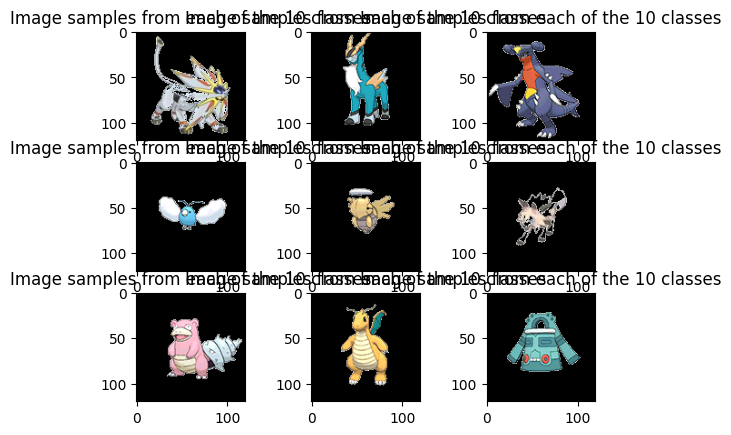

In [793]:
for i in range(9):
    plt.subplot(3,3, i + 1)
    img = train_dataset[i][0]
    plot_img(img)
    # plt.imshow(img)

# plt.show()

In [794]:
# Build model

class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1,)
        self.conv2 = nn.Conv2d(32,64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 30 * 30, 120)
        self.fc2 = nn.Linear(120, len(classes))

    def forward(self, x):
        # [(W−K+2P)/S]+1
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        # Conv to Linear
        x = x.view(-1, 64 * 30 * 30)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        # x = torch.softmax(x, dim=1)
        return x


In [795]:
device = torch.device('cpu')

model = Classifier()

model = model.to(device)

print(model)

Classifier(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=57600, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=18, bias=True)
)


In [396]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    acc = torch.round(acc * 100)
    return acc

In [796]:
from torch.utils.data import DataLoader
import torch.optim as optim

batch_size = 32
optimizer = optim.Adam(model.parameters(), lr= 1e-3)
criterion = nn.CrossEntropyLoss()

num_epochs = 10


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

model.train()
for epoch in range(num_epochs):
    running_loss = 0

    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    epoch_loss = running_loss / len(train_dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

Epoch [1/10], Loss: 0.0939
Epoch [2/10], Loss: 0.0891
Epoch [3/10], Loss: 0.0867
Epoch [4/10], Loss: 0.0839
Epoch [5/10], Loss: 0.0792
Epoch [6/10], Loss: 0.0742
Epoch [7/10], Loss: 0.0678
Epoch [8/10], Loss: 0.0608
Epoch [9/10], Loss: 0.0507
Epoch [10/10], Loss: 0.0358


In [257]:
print(test_dataset[2][1].shape)

torch.Size([])


In [797]:
from sklearn.metrics import accuracy_score
# Evaluation
model.eval()
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        # _, predicted = torch.max(outputs, 2)
        max_index = np.argmax(outputs, axis=1)

        one_hot = np.zeros_like(outputs)
        one_hot[np.arange(len(outputs)), max_index] = 1
        
        total += labels.size(0)
        c = (torch.tensor(one_hot) == labels).sum().item() / 18
        correct += c


print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 90 %


In [805]:
decoder = label_encoder.inverse_transform

i = 50

p = model(train_dataset[i][0]).detach().numpy()

max_index = np.argmax(p)

one_hot = np.zeros_like(p)
one_hot[np.arange(len(p)), max_index] = 1


print(f'Predicted: {decoder(one_hot)}')
print(f'Original : {decoder([np.array(train_dataset[i][1])])}')
# decoder([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]])

Predicted: [['Dark']]
Original : [['Dark']]
